Question 1. (Univariate B-spline implementation)
The B-splines make a set of base function for function approximation and the high-order B-splines can be defined by recursion: given the knots $
\{t_i\}_{i\in\mathcal{I}}$
\begin{align*}
    & B_{i , 1} := \text{Indicator}([t_i, t_{i+1})),\\
    & B_{i, k+1} := w_{i,k}(x)\cdot B_{i,k}(x) + (1 - w_{i+1, k})\cdot B_{i+1, k}(x),\\
    & w_{i,k} := \frac{x - t_{i}}{t_{i+k} - t_{i}}~or\quad 0~\text{otherwise}.
\end{align*}
Then the approximation reduces to the linear regression with feature functions to be $\{B_{i, degree}\}_{i\in\mathcal{I}}$.

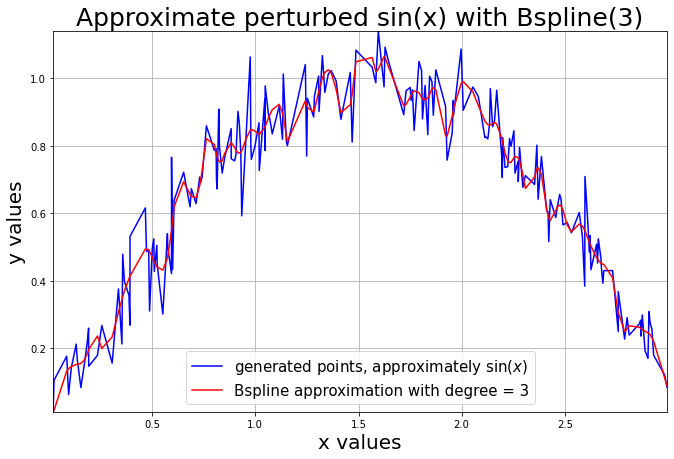

In [30]:
from rl.function_approx import LinearFunctionApprox, X, AdamGradient, Weights
from typing import Sequence, Callable, Optional
import numpy as np

class UBspline(LinearFunctionApprox[X]):

    @staticmethod
    def create(
        start: float,
        end: float,
        step: float,
        degree: int,
        adam_gradient: AdamGradient = AdamGradient.default_settings(),
        regularization_coeff: float = 0.,
        weights: Optional[Weights] = None,
        direct_solve: bool = True
    ) -> LinearFunctionApprox[X]:
        knots = list(np.arange(start, end + degree * step, step))
        if len(knots) < degree:
            raise ValueError()

        def indicator(a: float, b: float) -> Callable[[X], float]:
            return lambda s: 1 if b > s >= a else 0
        def indicator_alter(a: float) -> Callable[[X], float]:
            return lambda s: 1 if s >= a else 0
        def rec_Bspline(f: Callable[[X], float],
                        g: Callable[[X], float],
                        knots: Sequence[float],
                        order: int, #order = k, in formula above
                        index: int #order = i
            ) -> Callable[[X], float]:

            def weight( knots: Sequence[float],
                        order: int,
                        index: int
            ) -> float:
                return lambda x: (x - knots[index])/(knots[index + order] - knots[index]) if index + order < len(knots) else 0

            return lambda x: weight(knots, order, index)(x) * f(x) + (1 - weight(knots, order, index)(x)) * g(x)

        feature_functions: Sequence[Callable[[X], float]] = []
        for order in range(1, degree + 1):
            new_features: Sequence[Callable[[X], float]] = []
            if order == 1:
                new_features += [indicator(knots[index], knots[index + 1]) for index in range(len(knots) - 1)]
            else:
                new_features += [rec_Bspline(rec_features[index], rec_features[index + 1], knots, order, index)
                                 for index in range(len(knots) - order)]

            rec_features: Sequence[Callable[[X], float]] = new_features

        return LinearFunctionApprox.create(
            feature_functions = rec_features,
            regularization_coeff = regularization_coeff,
            weights = Weights.create(
                adam_gradient = adam_gradient,
                weights = np.zeros(len(rec_features))
            ) if weights is None else weights,
            direct_solve = direct_solve
        )

import matplotlib.pyplot as plt

x_val: np.ndarray = np.sort(np.random.rand(200) * 3)
y_val: np.ndarray = np.random.normal(0, 0.08, 200) + np.sin(x_val)
data = zip(list(x_val), list(y_val))

user_degree: int = 3

approx = UBspline.create(start = 0,
                         end = 3,
                         step = 0.05,
                         degree = user_degree,
                         regularization_coeff = 0.)

solved: LinearFunctionApprox[X] = approx.solve(data)
approx_y_val: np.ndarray = solved.evaluate(x_val)

from rl.gen_utils.plot_funcs import plot_list_of_curves
import os

plot_list_of_curves(
        [x_val, x_val],
        [y_val, approx_y_val],
        ["b", "r"],
        [
            r"generated points, approximately $\sin(x)$",
            f"Bspline approximation with degree = {user_degree}"
        ],
        "x values",
        "y values",
        f"Approximate perturbed sin(x) with Bspline({user_degree})"
)